<a href="https://colab.research.google.com/github/hpsuresh12345/Python-code/blob/master/Cisco_16Dec2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objective:
1.Apply your financial and analytical knowledge to determine key trends and pattern in the data. What are your observations?

2.How can Stark predict future Cashflow for each line items?

3.If Stark has to make the prediction of "Net Income" for next 2 quarters, shall he use the line items-basedforecast or overall "Net Income" forecast? Why?

4.How can Stark make a forecast for items that don't show a trend?

5.Predict the "Net Income" for next 2 quarters? What business thought processes and/orstatisticaltechniques did you use? Why? How confident are you in your predictions? What would you advise to Stark?

In [0]:
#Importing necessary libraries

import pandas as pd
import numpy as np
import pandas_profiling
import datetime as dt
import warnings
warnings.filterwarnings('ignore') 

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Dataset

In [0]:
#loading the data

df = pd.read_excel("cisco.xlsx", sheet_name="Sheet2", skiprows=1, index_col=None)

In [162]:
df.head()

,Unnamed: 0,Unnamed: 1,Qtr Ending,Qtr Ending.1,Qtr Ending.2,Qtr Ending.3,Qtr Ending.4,Qtr Ending.5,Qtr Ending.6,Qtr Ending.7,Qtr Ending.8,Qtr Ending.9,Qtr Ending.10,Qtr Ending.11,Qtr Ending.12,Qtr Ending.13,Qtr Ending.14,Qtr Ending.15,Qtr Ending.16,Qtr Ending.17,Qtr Ending.18,Qtr Ending.19,Qtr Ending.20,Qtr Ending.21,Qtr Ending.22,Qtr Ending.23,Qtr Ending.24,Qtr Ending.25
0,NaN,NaN,2009-10-24 00:00:00,2010-01-23 00:00:00,2010-05-01 00:00:00,2010-07-31 00:00:00,2010-10-30 00:00:00,2011-01-29 00:00:00,2011-04-30 00:00:00,2011-07-30 00:00:00,2011-10-29 00:00:00,2012-01-28 00:00:00,2012-04-28 00:00:00,2012-07-28 00:00:00,2012-10-27 00:00:00,2013-01-26 00:00:00,2013-04-27 00:00:00,2013-07-27 00:00:00,2013-10-26 00:00:00,2014-01-25 00:00:00,2014-04-26 00:00:00,2014-07-26 00:00:00,2014-10-25 00:00:00,2015-01-24 00:00:00,2015-04-25 00:00:00,2015-07-25 00:00:00,2015-10-24 00:00:00,2016-01-23 00:00:00
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NET SALES:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Product,7200,7976,8436,8808,8700,8236,8669,8921,8952,9118,9106,9150,9297,9437,9559,9736,9397,8423,8820,9532,9435,9078,9326,9911,9844,8983
4,NaN,Service,1821,1839,1932,2028,2050,2171,2197,2274,2304,2409,2482,2540,2579,2661,2657,2681,2688,2732,2725,2825,2810,2858,2811,2932,2838,2944


# Data Preprocessing

In [163]:
df.dropna(how="all",inplace=True)
df['Unnamed: 0'] = df['Unnamed: 0'].fillna(method='ffill')
df['Unnamed: 1'] = df['Unnamed: 1'].fillna(df['Unnamed: 0']) 
df = df.T[1:]
df.rename(columns = {'Unnamed: 1':'Qtr'}, inplace=True)
df.columns = df.iloc[0]
df = df.drop(['NET SALES:', 'COST OF SALES:', 'OPERATING EXPENSES:'], axis=1)
df = df.reset_index(level = 0, drop=True)
df = df.drop(df.index[0])
columns = ['Qtr','NETSales_Product','NETSales_Service','Total_NETSales','COSTSales_Product','COSTSales_Service',
           'Total_COSTSales','GROSS_MARGIN','OPEX_R_D','OPEX_Sales_Marketing','OPEX_General_Administrative','OPEX_Intag_Assets','OPEX_Restruct_OtherCharges',
           'Total_OPEX','OPIN','Interest_Income','Interest_Expense','Other_Income','NetInterest_OtherIncome',
           'INCOME_BeforeTax', 'PROVISION_for_Income_Taxes','NET_INCOME']
df.columns = columns
df.head()
df.shape

,Qtr,NETSales_Product,NETSales_Service,Total_NETSales,COSTSales_Product,COSTSales_Service,Total_COSTSales,GROSS_MARGIN,OPEX_R_D,OPEX_Sales_Marketing,OPEX_General_Administrative,OPEX_Intag_Assets,OPEX_Restruct_OtherCharges,Total_OPEX,OPIN,Interest_Income,Interest_Expense,Other_Income,NetInterest_OtherIncome,INCOME_BeforeTax,PROVISION_for_Income_Taxes,NET_INCOME
1,2009-10-24,7200,1821,9021,2486,647,3133,5888,1224,2010,425,105,134,3898,1990,168,-114,61,115,2105,452,1653
2,2010-01-23,7976,1839,9815,2815,668,3483,6332,1247,2126,451,138,134,4096,2236,155,-158,-12,-15,2221,502,1719
3,2010-05-01,8436,1932,10368,3010,728,3738,6630,1411,2278,479,117,134,4419,2211,158,-182,82,58,2269,211,2058
4,2010-07-31,8808,2028,10836,3309,734,4043,6793,1391,2368,578,131,134,4602,2191,154,-169,108,93,2284,483,1801
5,2010-10-30,8700,2050,10750,3249,746,3995,6755,1431,2402,458,113,134,4538,2217,160,-166,80,74,2291,495,1796


(26, 22)

In [164]:
df['Qtr'] = df.index.values
df.head()
df.tail()
df.columns

,Qtr,NETSales_Product,NETSales_Service,Total_NETSales,COSTSales_Product,COSTSales_Service,Total_COSTSales,GROSS_MARGIN,OPEX_R_D,OPEX_Sales_Marketing,OPEX_General_Administrative,OPEX_Intag_Assets,OPEX_Restruct_OtherCharges,Total_OPEX,OPIN,Interest_Income,Interest_Expense,Other_Income,NetInterest_OtherIncome,INCOME_BeforeTax,PROVISION_for_Income_Taxes,NET_INCOME
1,1,7200,1821,9021,2486,647,3133,5888,1224,2010,425,105,134,3898,1990,168,-114,61,115,2105,452,1653
2,2,7976,1839,9815,2815,668,3483,6332,1247,2126,451,138,134,4096,2236,155,-158,-12,-15,2221,502,1719
3,3,8436,1932,10368,3010,728,3738,6630,1411,2278,479,117,134,4419,2211,158,-182,82,58,2269,211,2058
4,4,8808,2028,10836,3309,734,4043,6793,1391,2368,578,131,134,4602,2191,154,-169,108,93,2284,483,1801
5,5,8700,2050,10750,3249,746,3995,6755,1431,2402,458,113,134,4538,2217,160,-166,80,74,2291,495,1796


,Qtr,NETSales_Product,NETSales_Service,Total_NETSales,COSTSales_Product,COSTSales_Service,Total_COSTSales,GROSS_MARGIN,OPEX_R_D,OPEX_Sales_Marketing,OPEX_General_Administrative,OPEX_Intag_Assets,OPEX_Restruct_OtherCharges,Total_OPEX,OPIN,Interest_Income,Interest_Expense,Other_Income,NetInterest_OtherIncome,INCOME_BeforeTax,PROVISION_for_Income_Taxes,NET_INCOME
22,22,9078,2858,11936,3806,1040,4846,7090,1529,2308,490,72,69,4468,2622,189,-139,201,251,2873,476,2397
23,23,9326,2811,12137,3584,1028,4612,7525,1547,2449,510,70,24,4600,2925,190,-139,59,110,3035,598,2437
24,24,9911,2932,12843,4068,1042,5110,7733,1548,2549,536,146,73,4852,2881,211,-149,-10,52,2933,614,2319
25,25,9844,2838,12682,3853,997,4850,7832,1560,2443,539,69,142,4753,3079,225,-159,-8,58,3137,707,2430
26,26,8983,2944,11927,3480,1015,4495,7432,1509,2286,176,71,96,4138,3294,237,-162,-63,12,3306,159,3147


Index(['Qtr', 'NETSales_Product', 'NETSales_Service', 'Total_NETSales',
       'COSTSales_Product', 'COSTSales_Service', 'Total_COSTSales',
       'GROSS_MARGIN', 'OPEX_R_D', 'OPEX_Sales_Marketing',
       'OPEX_General_Administrative', 'OPEX_Intag_Assets',
       'OPEX_Restruct_OtherCharges', 'Total_OPEX', 'OPIN', 'Interest_Income',
       'Interest_Expense', 'Other_Income', 'NetInterest_OtherIncome',
       'INCOME_BeforeTax', 'PROVISION_for_Income_Taxes', 'NET_INCOME'],
      dtype='object')

In [165]:
df.describe()
df.info()

,Qtr
count,26.000000
mean,13.500000
std,7.648529
min,1.000000
25%,7.250000
50%,13.500000
75%,19.750000
max,26.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 1 to 26
Data columns (total 22 columns):
Qtr                            26 non-null int64
NETSales_Product               26 non-null object
NETSales_Service               26 non-null object
Total_NETSales                 26 non-null object
COSTSales_Product              26 non-null object
COSTSales_Service              26 non-null object
Total_COSTSales                26 non-null object
GROSS_MARGIN                   26 non-null object
OPEX_R_D                       26 non-null object
OPEX_Sales_Marketing           26 non-null object
OPEX_General_Administrative    26 non-null object
OPEX_Intag_Assets              26 non-null object
OPEX_Restruct_OtherCharges     26 non-null object
Total_OPEX                     26 non-null object
OPIN                           26 non-null object
Interest_Income                26 non-null object
Interest_Expense               26 non-null object
Other_Income                   26 non-null objec

In [166]:
EDA_report = pandas_profiling.ProfileReport(df)
EDA_report

Number of variables,23
Number of observations,26
Total Missing (%),0.0%
Total size in memory,4.8 KiB
Average record size in memory,188.9 B
Numeric,22
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,1


# Splitting the data into 3 sub data sets
Dataset 1 - Individual Items (Without Totals),
Dataset 2 - Item Sub Totals,
Dataset 3 - Net Income

# dataset 1

In [167]:
df_items = df.loc[:,('Qtr','NETSales_Product', 'NETSales_Service', 'COSTSales_Product', 'COSTSales_Service', 
                     'OPEX_R_D', 'OPEX_Sales_Marketing', 'OPEX_General_Administrative', 'OPEX_Intag_Assets', 'OPEX_Restruct_OtherCharges',
                    'Interest_Income','Interest_Expense','Other_Income','PROVISION_for_Income_Taxes','NET_INCOME')]
df_items.head()
df_items.shape

,Qtr,NETSales_Product,NETSales_Service,COSTSales_Product,COSTSales_Service,OPEX_R_D,OPEX_Sales_Marketing,OPEX_General_Administrative,OPEX_Intag_Assets,OPEX_Restruct_OtherCharges,Interest_Income,Interest_Expense,Other_Income,PROVISION_for_Income_Taxes,NET_INCOME
1,1,7200,1821,2486,647,1224,2010,425,105,134,168,-114,61,452,1653
2,2,7976,1839,2815,668,1247,2126,451,138,134,155,-158,-12,502,1719
3,3,8436,1932,3010,728,1411,2278,479,117,134,158,-182,82,211,2058
4,4,8808,2028,3309,734,1391,2368,578,131,134,154,-169,108,483,1801
5,5,8700,2050,3249,746,1431,2402,458,113,134,160,-166,80,495,1796


(26, 15)

# dataset2

In [168]:
df_item_totals = df.loc[:,('Qtr','Total_NETSales', 'Total_COSTSales', 'GROSS_MARGIN','Total_OPEX', 'OPIN', 'NetInterest_OtherIncome','INCOME_BeforeTax','PROVISION_for_Income_Taxes', 'NET_INCOME')]
df_item_totals.head()
df_item_totals.shape

,Qtr,Total_NETSales,Total_COSTSales,GROSS_MARGIN,Total_OPEX,OPIN,NetInterest_OtherIncome,INCOME_BeforeTax,PROVISION_for_Income_Taxes,NET_INCOME
1,1,9021,3133,5888,3898,1990,115,2105,452,1653
2,2,9815,3483,6332,4096,2236,-15,2221,502,1719
3,3,10368,3738,6630,4419,2211,58,2269,211,2058
4,4,10836,4043,6793,4602,2191,93,2284,483,1801
5,5,10750,3995,6755,4538,2217,74,2291,495,1796


(26, 10)

# dataset 3

In [169]:
df_NetIncome = pd.DataFrame(df,columns=['Qtr','NET_INCOME'])
df_NetIncome.head()
df_NetIncome.shape

,Qtr,NET_INCOME
1,1,1653
2,2,1719
3,3,2058
4,4,1801
5,5,1796


(26, 2)

# visualize the net income trend

<Figure size 1000x600 with 0 Axes>

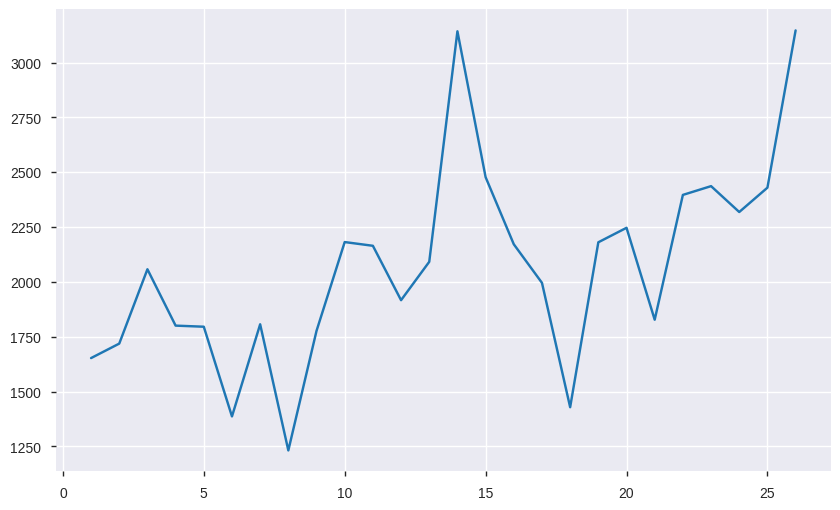

In [170]:
#plot
plt.figure(figsize=(10,6))
plt.plot(df_NetIncome['NET_INCOME'], label='NET_INCOME')

Simple Linear Regression on individual Cash flow items

In [0]:
# Importing Necessary Libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [172]:
df2 = pd.DataFrame()
lst_rmse = []
lst_r2=[]
lst_coeff = []
lst_ypred27 = []
lst_ypred28 = []
Y=[]
for column in df_item_totals:
    X = df_item_totals['Qtr'].values
    Y_OL = df_item_totals[column].values
    m = len(X)
    df2['Items'] = df_item_totals.columns
    Y = outliers(Y_OL)
    # Mean X and Y
    mean_x = np.mean(X)
    mean_y = np.mean(Y)
    b0, b1 = coeff(X,Y)
    lst_coeff.append([b0, b1])
    lst_rmse.append(rms(X,Y,m))
    lst_r2.append(r_square(X,Y))
    lst_ypred27.append(coeff(X,Y)[0] + coeff(X,Y)[1] * 27) 
    lst_ypred28.append(coeff(X,Y)[0] + coeff(X,Y)[1] * 28) 
df2['Coefficients'] = lst_coeff
df2['RMSE'] = lst_rmse
df2['R_Square'] = lst_r2
df2['Qtr_27_Predicted'] = lst_ypred27
df2['Qtr_28_Predicted'] = lst_ypred28

df2.index = df2['Items']
df2 = df2.drop('Items', axis=1)
df2 = df2.drop(df2.index[0])
df2

,Coefficients,RMSE,R_Square,Qtr_27_Predicted,Qtr_28_Predicted
Items,,,,,
Total_NETSales,"[10511.770650887574, 79.78556213017751]",437.949932,0.651192,12665.980828,12745.766391
Total_COSTSales,"[4103.432426035503, 34.007416173570014]",240.920383,0.528477,5021.632663,5055.640079
GROSS_MARGIN,"[6548.204497041421, 41.28596975673898]",226.583438,0.651270,7662.925680,7704.211650
Total_OPEX,"[4474.078224852071, 6.754451019066402]",203.701671,0.058244,4656.448402,4663.202853
OPIN,"[2117.861775147929, 29.952820512820512]",277.185390,0.396440,2926.587929,2956.540750
NetInterest_OtherIncome,"[38.80307692307692, 0.5466929651545037]",39.146364,0.010851,53.563787,54.110480
INCOME_BeforeTax,"[2153.4286390532548, 31.445128205128206]",262.359560,0.446916,3002.447101,3033.892229
PROVISION_for_Income_Taxes,"[394.9224852071006, 5.191913214990137]",129.381897,0.083056,535.104142,540.296055
NET_INCOME,"[1641.9143195266274, 25.492649572649572]",263.769305,0.344441,2330.215858,2355.708508


In [173]:
NET_INCOME1 = df2.Qtr_27_Predicted[0] - df2.Qtr_27_Predicted[1] - df2.Qtr_27_Predicted[3] + df2.Qtr_27_Predicted[5] - df2.Qtr_27_Predicted[7]


print("Net Income for Qtr 27 is :", NET_INCOME1)

Net Income for Qtr 27 is : 2506.3594082840236


In [174]:
NET_INCOME2 = df2.Qtr_28_Predicted[0] - df2.Qtr_28_Predicted[1] - df2.Qtr_28_Predicted[3] + df2.Qtr_28_Predicted[5] - df2.Qtr_28_Predicted[7]


print("Net Income for Qtr 28 is :", NET_INCOME2)

Net Income for Qtr 28 is : 2540.737882971729


# approach 2


In [175]:
df3 = pd.DataFrame()
lst_rmse = []
lst_r2=[]
lst_coeff = []
lst_ypred27 = []
lst_ypred28 = []
lst_y_pred = []
Y=[]
X = df['GROSS_MARGIN'].values
Y_OL = df['NET_INCOME'].values
Y = outliers(Y_OL)
m = len(X)

# Mean X and Y
mean_x = np.mean(X)
mean_y = np.mean(Y)
b0, b1 = coeff(X,Y)
lst_coeff.append([b0, b1])
lst_rmse.append(rms(X,Y,m))
lst_r2.append(r_square(X,Y))
lst_ypred27.append(coeff(X,Y)[0] + coeff(X,Y)[1] * 7664.426561) 
lst_ypred28.append(coeff(X,Y)[0] + coeff(X,Y)[1] * 7712.078297) 
df3['Coefficients'] = lst_coeff
df3['RMSE'] = lst_rmse
df3['R_Square'] = lst_r2
df3['Qtr_27_Predicted'] = lst_ypred27
df3['Qtr_28_Predicted'] = lst_ypred28

for i in range(m):
    y_pred = b0 + b1 * X[i]
    lst_y_pred.append(y_pred)

df_Gross_Margin = pd.DataFrame()
df_Gross_Margin['Qtr']= df['Qtr']
df_Gross_Margin['GROSS_MARGIN'] = df['GROSS_MARGIN'] 
df_Gross_Margin['NET_INCOME'] = Y 
df_Gross_Margin['NET_INCOME_Predicted'] = lst_y_pred

df_Gross_Margin

df3

,Qtr,GROSS_MARGIN,NET_INCOME,NET_INCOME_Predicted
1,1,5888,1653.000000,1421.452564
2,2,6332,1719.000000,1642.742949
3,3,6630,2058.000000,1791.266675
4,4,6793,1801.000000,1872.506163
5,5,6755,1796.000000,1853.566896
6,6,6261,1387.000000,1607.356423
7,7,6659,1807.000000,1805.720326
8,8,6861,1232.000000,1906.397483
9,9,6890,1777.000000,1920.851135
10,10,7065,2182.000000,2008.071444


,Coefficients,RMSE,R_Square,Qtr_27_Predicted,Qtr_28_Predicted
0,"[-1513.1370384054853, 0.4984017667508569]",211.140926,0.579943,2306.826701,2330.57641


Text(0.5, 1.0, 'Actual Net Income vs Predicted Net Income')

Text(0.5, 0, 'Actual Net Income')

Text(0, 0.5, 'Predicted Net Income')

No handles with labels found to put in legend.


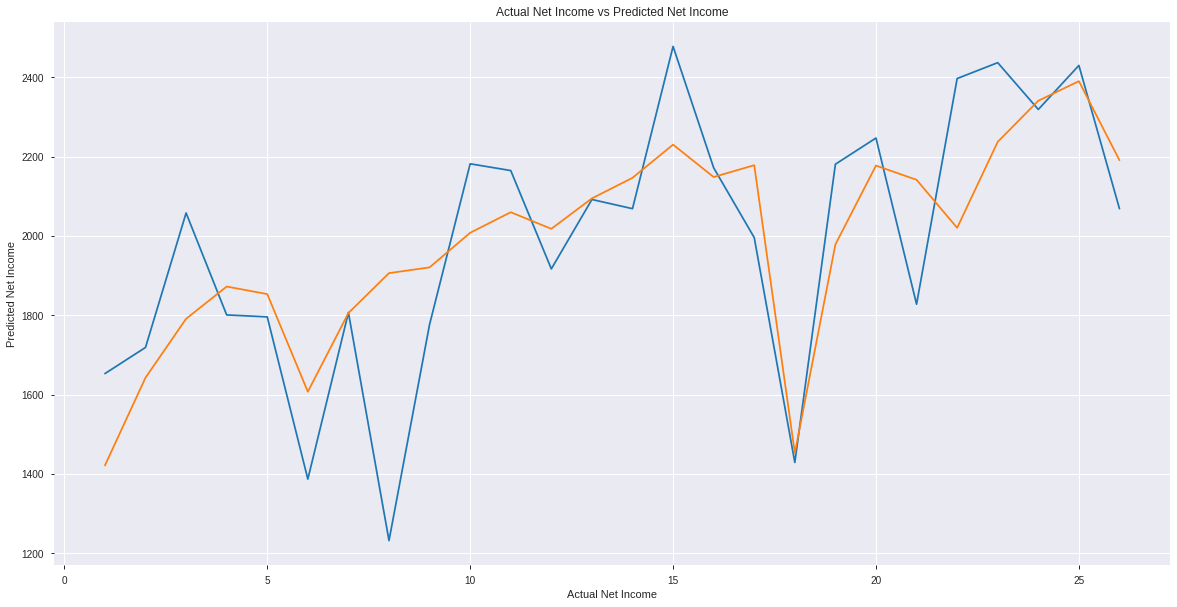

In [176]:
plt.plot(df_Gross_Margin['NET_INCOME'])
plt.plot(df_Gross_Margin['NET_INCOME_Predicted'])
plt.title("Actual Net Income vs Predicted Net Income")
plt.xlabel('Actual Net Income')
plt.ylabel('Predicted Net Income')
plt.legend()

# using scikit learn

In [0]:
#implement linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [178]:
df_items.head()

,Qtr,NETSales_Product,NETSales_Service,COSTSales_Product,COSTSales_Service,OPEX_R_D,OPEX_Sales_Marketing,OPEX_General_Administrative,OPEX_Intag_Assets,OPEX_Restruct_OtherCharges,Interest_Income,Interest_Expense,Other_Income,PROVISION_for_Income_Taxes,NET_INCOME
1,1,7200,1821,2486,647,1224,2010,425,105,134,168,-114,61,452,1653
2,2,7976,1839,2815,668,1247,2126,451,138,134,155,-158,-12,502,1719
3,3,8436,1932,3010,728,1411,2278,479,117,134,158,-182,82,211,2058
4,4,8808,2028,3309,734,1391,2368,578,131,134,154,-169,108,483,1801
5,5,8700,2050,3249,746,1431,2402,458,113,134,160,-166,80,495,1796


In [0]:
X =  df_items.iloc[:,1:14]
Y =  df_items.iloc[:,14:]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,  random_state=None, shuffle=False)

In [188]:
slr = LinearRegression()
slr.fit(X_train,y_train)

#make predictions and find the rmse

y_pred = slr.predict(X_test)

# Model Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE Value :", rmse)
print("R-Squared Value :", r2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

RMSE Value : 1.3853943536280373e-12
R-Squared Value : 1.0


No handles with labels found to put in legend.


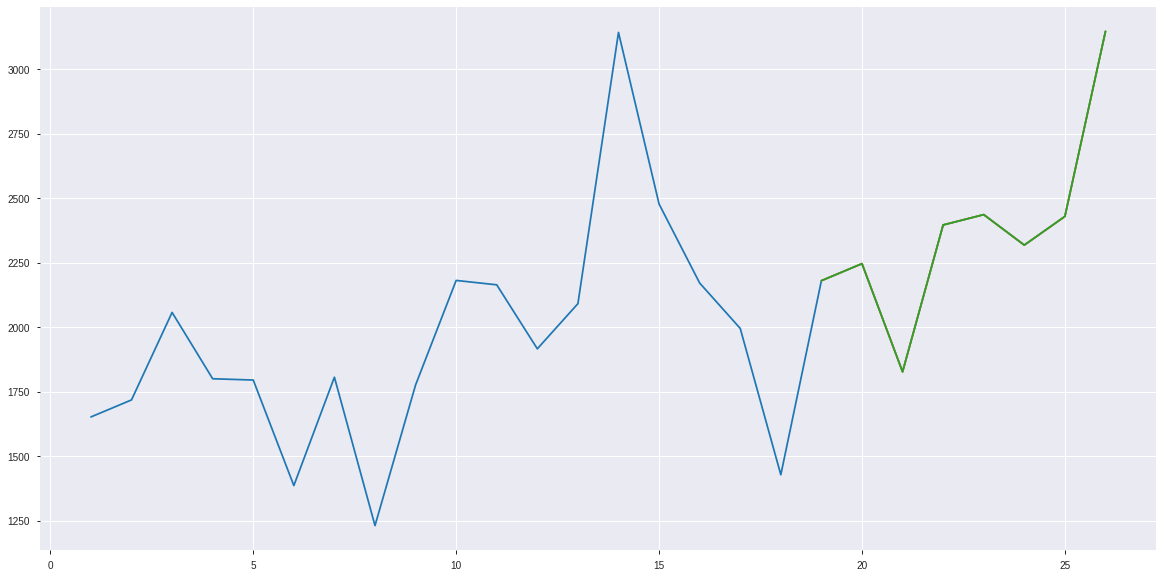

In [189]:
#plot
y_test['Predictions'] = 0
y_test['Predictions'] = y_pred

plt.plot(df_items['NET_INCOME'])
plt.plot(y_test[['NET_INCOME', 'Predictions']])
plt.legend()